# Cell segmentation
We can use the high resolution tissue images to segment nuclei. This information can be used as additional features. Wr provide two segmentation models `SegmentationModelBlob` and `SegmentationModelWatershed`. In addition, you can use your own pre-tranined `tensorflow.keras` model to do the segmentation.

In this notebook, we show how to use the segmentation models and what kind of parameters you can use.

In [1]:
# import modules
import squidpy as sq
import os
import numpy as np
import matplotlib.pyplot as plt

/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/docrep/decorators.py:26: SyntaxWarning: 'xy_coord' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
# set path to dataset
BASE_PATH = "../../data"

## Load data
Here, we use a human brain fluorescence dataset

In [3]:
# set path to dataset
BASE_PATH = "../../data"
dataset_folder = os.path.join(BASE_PATH, "2020_10XFluoVisium_HumanBrain1_giovanni.palla")
# load data
adata, img = sq.read_visium_data(dataset_folder)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
crop = img.crop_corner(10000, 10000, xs=1000, ys=1000)

In [10]:
seg1 = sq.im.segment_img(img=crop, img_id="image", model_group="watershed", channel_idx=0,
              model_kwargs={'thresh': 50000}, xs=100, ys=100)
seg2 = sq.im.segment_img(img=crop, img_id="image", model_group="watershed", channel_idx=0,
              model_kwargs={'thresh': 50000})

ImageContainer object with 1 layers
    image: y (24240), x (24240), channels (4)



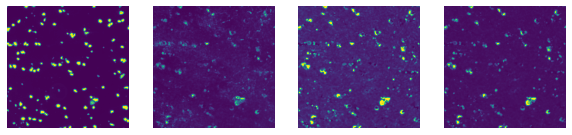

In [4]:
print(img)

# plot small example crop from img
crop = img.crop_corner(10000, 10000, xs=1000, ys=1000)

fig, axes = plt.subplots(1,4, figsize=(10,20))
for i,ax in enumerate(axes):
    ax.imshow(crop['image'][:,:,i])
    ax.axis('off')

stain 0 is DAPI, allows to distinguish individual nuclei

(array([7.3543e+04, 2.2239e+04, 6.4400e+02, 1.9300e+02, 1.2900e+02,
        7.7000e+01, 7.8000e+01, 2.1000e+01, 1.4000e+01, 2.2000e+01]),
 array([ 1536. ,  7926.4, 14316.8, 20707.2, 27097.6, 33488. , 39878.4,
        46268.8, 52659.2, 59049.6, 65440. ]),
 <BarContainer object of 10 artists>)

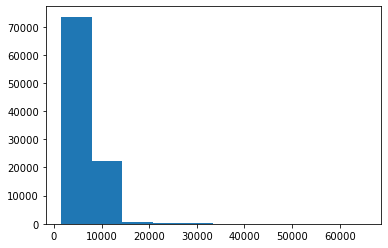

In [5]:
# plot histogram for 0th stain to identify an adequate threshold
plt.hist(np.asarray(img.data["image"][0]).flatten())

there is a small peak at 60000, lets choose 50000 as a threshold for the watershed segmentation

## Segmentation cells using watershed
We use `sq.im.segment_img` to segment an layer of an ImageContainer. For large images, you can choose to tile the image in smaller crops and process them individually.

Small crops can be segmented at once. By default, `segment_img` adds the segmented image in the input image. This behaviour can be controlled using the `copy` flag.

In [32]:
sq.im.segment_img(img=crop, img_id="image", model_group="watershed", channel_idx=1,
              model_kwargs={'thresh': 50000})

display(crop)

ImageContainer object with 2 layers
    image: y (1000), x (1000), channels (4)
    segmented_watershed: y (1000), x (1000), mask (1)

The segmented crop is saved in the layer `segmented_watershed`

Text(0.5, 1.0, 'segmentation')

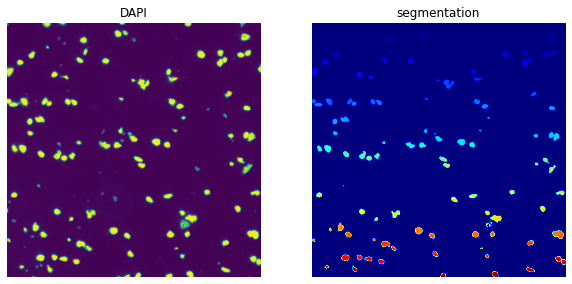

In [10]:
# plot example result
fig, axes = plt.subplots(1,2, figsize=(10,20))
axes[0].imshow(crop['image'][:,:,0])
axes[0].axis('off')
axes[0].set_title('DAPI')

axes[1].imshow(crop['segmented_watershed'], cmap='jet')
axes[1].axis('off')
axes[1].set_title('segmentation')

The result of the segmentation is a label image that can be used to extract features like number of cells from the image.

We can also apply the segmentation to an entire tissue image by tiling the image in smaller crops. This is done automatically, when `xs` and `ys` are defined.

In [14]:
sq.im.segment_img(img=img, img_id="image", model_group="watershed", channel_idx=0,
              model_kwargs={'thresh': 50000}, xs=1000, ys=1000)

display(img)

ImageContainer object with 2 layers
    image: y (24240), x (24240), channels (4)
    segmented_watershed: y (24240), x (24240), mask (1)

Text(0.5, 1.0, 'segmentation')

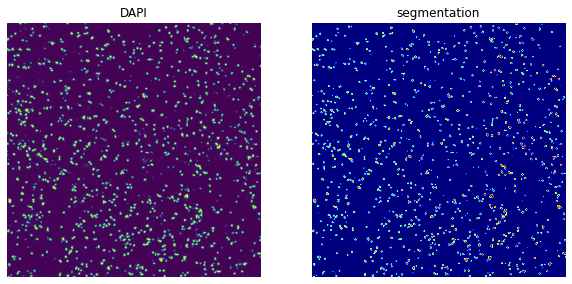

In [26]:
# plot example result
cur_crop = img.crop_corner(10000, 10000, xs=3000, ys=3000)

fig, axes = plt.subplots(1,2, figsize=(10,20))
axes[0].imshow(cur_crop['image'][:,:,0])
axes[0].axis('off')
axes[0].set_title('DAPI')

axes[1].imshow(cur_crop['segmented_watershed'], cmap='jet')
axes[1].axis('off')
axes[1].set_title('segmentation')

We can use the calculated segmentation to extract segmentation-based features

# TODO

In [199]:
import skimage.measure
def get_segmentation_features(img, features_name='segmentation', props=['label', 'area', 'eccentricity']):
    img.data['segmented_watershed']
    
    res = skimage.measure.regionprops_table(img.data['segmented_watershed'][0].values, #img.data['crop'][1].values,
                                        properties=['label', 'area', 'eccentricity', 'solidity', 'mean_intensity'])
    num_segments = len(res['label'])
    mean_area = np.mean(res['area'])
    mean_eccentricity = np.mean(res['eccentricity'])
    #mean_intensity = np.mean(res['mean_intensity'])
    print(res)
    #mean_solidity = np.mean('solidity')
    # todo could add mean intensity of specific channel
    return [num_segments, mean_area, mean_eccentricity]# mean_solidity]

get_segmentation_features(crop)
    

KeyError: 'mean_intensity'